# Scattertext
- Scattertext is a Python package for creating interactive scatterplots over language data. There is substantial code to produce keyness and dispersion metrics and visualizations. 
- It has been under development since 2016. I've written >99% of the code in the package. This is a passion project for me and absolutely not associated with my day job.
- It has a permissive Apache 2.0 license.
- http://www.github.com/jasonkessler/scattertext

## Installation
- Recommended: install conda (https://docs.conda.io/projects/conda/en/stable/user-guide/install/index.html#installing-conda-on-a-system-that-has-other-python-installations-or-packages)
- Create a new virtual environment
 - `$ conda create -n st310 python=3.10`
- Activate it
 - `$ soure activate st310`
- Install spaCy
 - https://spacy.io/usage
- Install scattertext
 - `$pip3 install -U scattertext`
- If you'd like to use UMAP



## Caveats
- The documentation is vignette-based. Many features are undocumented. The code is still in beta. Breaking changes can be made at any time!
 - With this in mind, don't be afraid to look through the code, make changes, and get your hands dirty.
- Test case coverage could be a lot higher. Breaking changes may have been made which didn't trigger test case failures.
- The visualization framework is written in Javascript and D3 v4. Browsers do not consistently implement the same Javascript standard, and their implementations can shift version-to-version, etc. In other words, you may have to modify the Javascript code to fix your visualization.

## Agenda
- Introducing Scattertext

### Part 1. Visualizing two categories

- The Rotten Tomatoes Corpus
- Creating text-based corpora
- Counting terms
- Visualizing term counts
- How the visualization works
- Customizing the visualization; text colors 
- Scoring terms
- Visualizing term scores
- Using scattertext to train Gensim word embeddings
- Visualizing projections of word embeddings 
- Visualizing how similar words are used across-categories

### Part 2. Visualizing multiple categories
- The Arthur Conan Doyle corpus 



In [154]:
%load_ext autoreload
%autoreload 2
import os, json, re, sys, time, warnings, datetime, glob
sys.path.insert(0, '../scattertext/')

import scipy.stats as ss    
import pandas as pd
import scattertext as st
import numpy as np
import spacy
import umap # Optional


from tqdm.auto import tqdm
tqdm.pandas()

from IPython.display import IFrame
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:98% !important; }</style>"))

assert st.version >= [0, 1, 15] 

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [83]:
nlp = spacy.blank('en')
_ = nlp.add_pipe('sentencizer')

# Load the Rotten Tomatoes Movie Review Data Set (Pang and Lee 2002)

We parse each review with spaCy. On a 2018 Macbook Pro, this takes about 31 seconds. The progress bar tells us it has processed documents. Reviews include polarity (positive or negative) and the name of the movie being reviewed.  4,866 reviews are retained after filtering for plot descriptions.

Data set is from http://www.cs.cornell.edu/people/pabo/movie-review-data/

References:
* Bo Pang, Lillian Lee, and Shivakumar Vaithyanathan, Thumbs up? Sentiment Classification using Machine Learning Techniques, Proceedings of EMNLP 2002.

* Bo Pang and Lillian Lee, A Sentimental Education: Sentiment Analysis Using Subjectivity Summarization Based on Minimum Cuts, Proceedings of ACL 2004.

In [81]:
movie_full_df = st.SampleCorpora.RottenTomatoes.get_data().assign(
    category = lambda df: df.category.apply(
        lambda x: {'rotten': 'Negative', 'fresh': 'Positive', 'plot': 'Plot'}[x]),
    SpacyParse=lambda df: df.text.progress_apply(nlp)
)
movie_df = movie_full_df[lambda df: df.category.isin(['Negative', 'Positive'])]

  0%|          | 0/5022 [00:00<?, ?it/s]

### Describe statistics of review word lengths

In [92]:
movie_df.groupby('category').apply(lambda gdf: gdf.SpacyParse.apply(len).describe())

SpacyParse,count,mean,std,min,25%,50%,75%,max
category,,,,,,,,
Negative,2411.0,22.358772,9.772912,2.0,15.0,22.0,29.0,58.0
Positive,2455.0,22.745010,9.955164,2.0,15.0,22.0,29.0,59.0


### Examine a positive review

In [106]:
dict(movie_df[lambda df: df.category=='Positive'][['movie_name', 'text']].iloc[0])

{'movie_name': 'abandon',
 'text': 'Difficult to peg and just as hard to predict.'}

### Examine a negative review

In [107]:
dict(movie_df[lambda df: df.category=='Negative'][['movie_name', 'text']].iloc[0])

{'movie_name': 'abandon',
 'text': 'Gaghan captures the half-lit, sometimes creepy intimacy of college dorm rooms, a subtlety that makes the silly, over-the-top coda especially disappointing.'}

## Creating a corpus object in Scattertext
- The most straightforward way to visualize documents in Scattertext is to create a corpus object from a Pandas data frame. Each row corresponds to a single document, while columns indicate other data about each document. Scattertext has numerous classes available to represent corpora, but the one we will begin with is a `ParsedCorpus` generated by the `CorpusFromParsedDocuments` factory.
- Typically, each document has a category about which Scattertext can generate various keyness metrics and visualizations. The columns containing the category and parse are passed as `parse_col` and `parsed_col`, respectively.
- The corpus object contains feature representations of each document. These either be tokens that occur in the document (using a case-insensitive search) or other features, some of which are linked to character offsets or a searchable lexicon. These non-searchable features are called "non_text" features. For now, we'll generate simple token features. 
- To turn each document into a feature vector, we will use the `FlexibleNGrams` class. Here, we output all unigrams found in the spaCy parses, filtering out blank spaces. We also exclude terms used in less than 6 documents.

In [7]:
unigram_corpus = st.CorpusFromParsedDocuments(
    movie_df,
    category_col='category',
    parsed_col='SpacyParse',
    feats_from_spacy_doc=st.FlexibleNGrams(ngram_sizes=[1])
).build().filter_out(
    lambda x: len(x.strip()) < 1
).remove_terms_used_in_less_than_num_docs(
    threshold=6
)


In [114]:
#We'll create on which inclues the plots, for use later
unigram_corpus_full = st.CorpusFromParsedDocuments(
    movie_full_df,
    category_col='category',
    parsed_col='SpacyParse',
    feats_from_spacy_doc=st.FlexibleNGrams(ngram_sizes=[1])
).build().filter_out(
    lambda x: len(x.strip()) < 1
).remove_terms_used_in_less_than_num_docs(
    threshold=6
)

## Exploring the corpus

In [77]:
print("Number of terms in corpus:", unigram_corpus.get_num_terms())
print("Number of reviews in corpus:", unigram_corpus.get_num_docs())
print("Number of categories in corpus:", unigram_corpus.get_num_categories())
print("Categories in corpus:", unigram_corpus.get_categories())
print("First five terms (features) in corpus:", unigram_corpus.get_terms()[:5])

Number of terms in corpus: 2083
Number of reviews in corpus: 4866
Number of categories in corpus: 2
Categories in corpus: ['Negative', 'Positive']
First five terms (features) in corpus: ['captures', 'the', 'half', '-', ',']


## Statistics about terms in the corpus 

= We can retrieve the term-document matrix as a sparse matrix using the `get_term_doc_mat` method.

In [9]:
tdm = unigram_corpus.get_term_doc_mat()
tdm.todense().shape

(4866, 2083)

## TermRankers: objects used to collect category-level metrics for downstream use

- The output of these objects is data frames giving statistics at a category-level.
- These are used as part of `TermScorers` which produce category-association scores for terms.
- N.B.
    - Currently, only three are implemented, and the ones which rely on document size use feature counts found in the term-document matrix. 
    - This means that if >1-grams are present or features have been removed, these will provide inaccurate estimates of document size. Use caution when using these, but they may still yield interesting results.
- The first and simplest is called the `AbsoluteFrequencyRanker`, where the sum of the number of terms in each category is returned. The `label_append` is a string concatenated to each category's name. The `label_append` is useful if other category-specific metrics will be added to the data frame.

In [21]:
st.AbsoluteFrequencyRanker(unigram_corpus).get_ranks(label_append=' Count').head()

,Negative Count,Positive Count
term,,
captures,1,5
the,2287,2351
half,27,14
-,949,902
",",2148,2466


`OncePerDocFrequencyRanker` ignores terms that occur in more than one document.

In [20]:
st.OncePerDocFrequencyRanker(unigram_corpus).get_ranks(label_append=' Documents').head()

,Negative Documents,Positive Documents
term,,
captures,1,5
the,1364,1414
half,26,13
-,634,642
",",1366,1488


`DocLengthNormalizedFrequencyRanker` weights each term by its document percentage, i.e., 

$$\mbox{weight}_{t,c} = \sum_{\mbox{doc } d \ \in \mbox{category } c} \frac{\#(t, d)}{|d|}$$

In [13]:
st.DocLengthNormalizedFrequencyRanker(unigram_corpus).get_ranks(label_append=' Percentages').head()

/Users/jasonkessler/anaconda3/envs/py38/lib/python3.7/site-packages/scipy/sparse/base.py:595: RuntimeWarning: invalid value encountered in true_divide
  return np.true_divide(self.todense(), other)


,Negative Percentages,Positive Percentages
captures,0.041667,0.298333
the,115.924483,117.177789
half,1.340761,0.711467
-,50.754314,45.370685
",",108.902535,123.622976


### Custom TermRankers

We can implement our own term ranker by creating a subclass of `scattertext.termranking.TermRanker.TermRanker` or `st.TermRanker`. 

This custom ranker will return mean tf.idf scores for each document in a category. Note that the term frequencies are square-root scaled.

The `TermRanker.get_term_doc_mat()` returns a document-row/term-column CSR sparse matrix, with values indicating the number of times a term appeared in that document.

A data frame should be returned indexed on terms and with the index named "term".

In [59]:
class MeanTFIDF(st.TermRanker):
    def get_ranks(self, label_append: str=' mean tf.idf') -> pd.DataFrame:
        sqrt_tf = np.sqrt(self.get_term_doc_mat())
        idf = np.log(self._corpus.get_num_docs()/(tdm>0).sum(axis=0).A1)
        tfidf = sqrt_tf.multiply(idf).tocsr()
        y = self._corpus.get_category_ids()        
        return pd.DataFrame({
            cat+label_append : tfidf[y == cat_i, :].mean(axis=0).A1
            for cat_i, cat 
            in enumerate(self._corpus.get_categories())
        }).assign(
            term = self._corpus.get_terms()
        ).set_index('term')
            
        

In [60]:
MeanTFIDF(unigram_corpus).get_ranks().head()

,Negative mean tf.idf,Positive mean tf.idf
term,,
captures,0.002778,0.013642
the,0.397556,0.403445
half,0.052877,0.026372
-,0.416547,0.403839
",",0.368237,0.403435


## Plotting language difference between positive and negative reviews

- Scattertext projects unigrams on a scatterplot based on the rank of their frequencies in each category. 
- The placement and color of each term are given in the `plot_df` data frame, where `Xpos` and `Ypos` indicate term coordinates ($\in [0,1]^2$).
- Scattertext attempts to label as many points as possible on the plot.
- The ColorScore indicates which terms receive bluer (more positive) or more red (more negative) point colors. 
  - The score is based on the difference between the scaled category frequency ranks.
  - Terms receiving the highest and lowest scores are labeled "Top Newer" and "Top Older."
- The unusual terms in the corpus (as judged by a set of general-purpose term frequencies) are displayed in the Characteristic column. 
- The newer function `dataframe_scattertext` function renders the scatter plot.
- Clicking on a term displays its usage in context.
- The get_heading(corpus) function returns the metadata text for each document.

In [25]:
def get_heading(corpus: st.ParsedCorpus):
    return corpus.get_df().movie_name

plot_df = st.AbsoluteFrequencyRanker(unigram_corpus).get_ranks(label_append='').assign(
    X=lambda df: df.Positive,
    Y=lambda df: df.Negative,
    PosRank = lambda df: ss.rankdata(df.X, method='dense'),
    NegRank = lambda df: ss.rankdata(df.Y, method='dense'),
    Xpos=lambda df: st.scale(df.NegRank),
    Ypos=lambda df: st.scale(df.PosRank),
    ColorScore=lambda df: st.Scalers.scale_center_zero(df.Ypos - df.Xpos),
)

line_df = pd.DataFrame({
    'x': np.arange(0, 1, 0.01),
    'y' :np.arange(0, 1, 0.01),
})


html = st.dataframe_scattertext(
    unigram_corpus,
    plot_df=plot_df,
    category='Positive', 
    category_name='Positive',
    not_category_name='Negative',
    width_in_pixels=1000, 
    ignore_categories=False,    
    metadata=get_heading,
    color_score_column='ColorScore',
    left_list_column='ColorScore',
    show_characteristic=False,
    y_label='Positive Frequency Rank',
    x_label='Negative Frequency Rank',
    tooltip_columns=['PosRank', 'NegRank'],
    header_names={'upper': 'Top Positive', 'lower': 'Top Negative'},
    line_coordinates = line_df.to_dict('records'),   
)

fn = 'movie_denserank_unigrams.html'
with open(fn, 'w') as of:
    of.write(html)


IFrame(src=fn, width = 1300, height=700)

../scattertext/scattertext/Scalers.py:247: RuntimeWarning: invalid value encountered in true_divide
  vec_ss = (vec_ss - vec_ss.min()) * 1. / (vec_ss.max() - vec_ss.min())


Let's perform the same action, but let's swap absolute frequencies for Mean TF.IDF.

In [64]:
def get_heading(corpus: st.ParsedCorpus):
    return corpus.get_df().movie_name

plot_df = MeanTFIDF(unigram_corpus).get_ranks(label_append='').assign(
    X=lambda df: df.Positive,
    Y=lambda df: df.Negative,
    PosRank = lambda df: ss.rankdata(df.X, method='dense'),
    NegRank = lambda df: ss.rankdata(df.Y, method='dense'),
    Xpos=lambda df: st.scale(df.NegRank),
    Ypos=lambda df: st.scale(df.PosRank),
    ColorScore=lambda df: st.Scalers.scale_center_zero(df.X - df.Y),
)

line_df = pd.DataFrame({
    'x': np.arange(0, 1, 0.01),
    'y' :np.arange(0, 1, 0.01),
})


html = st.dataframe_scattertext(
    unigram_corpus,
    plot_df=plot_df,
    category='Positive', 
    category_name='Positive',
    not_category_name='Negative',
    width_in_pixels=1000, 
    ignore_categories=False,    
    metadata=get_heading,
    color_score_column='ColorScore',
    left_list_column='ColorScore',
    show_characteristic=False,
    y_label='Positive Mean TF.IDF Rank',
    x_label='Negative Mean TF.IDF Ranak',
    tooltip_columns=['Positive', 'Negative'],
    header_names={'upper': 'Top Positive', 'lower': 'Top Negative'},
    line_coordinates = line_df.to_dict('records'),   
)

fn = 'movie_mean_tf_idf_unigrams.html'
with open(fn, 'w') as of:
    of.write(html)


IFrame(src=fn, width = 1300, height=700)

In [50]:
plot_df

,Negative,Positive,X,Y,Xpos,Ypos,ColorScore
term,,,,,,,
captures,0.998378,1.001622,1.001622,0.998378,0.320782,0.679218,0.507622
the,0.989773,1.010227,1.010227,0.989773,0.376565,0.623435,0.548060
half,1.005489,0.994511,0.994511,1.005489,0.274688,0.725312,0.442662
-,1.001454,0.998546,0.998546,1.001454,0.300840,0.699160,0.484807
",",0.960460,1.039540,1.039540,0.960460,0.566590,0.433410,0.685813
...,...,...,...,...,...,...,...
unfaithful,1.000045,0.999955,0.999955,1.000045,0.309979,0.690021,0.499534
lyne,1.000437,0.999563,0.999563,1.000437,0.307434,0.692566,0.495434
wallace,1.001267,0.998733,0.998733,1.001267,0.302057,0.697943,0.486768


# Keyness in Scattertext: Term Scorers

- Given a corpus, we can produce scores and statistics for how associated features are to a particular category.
- Subclasses of `CorpusBasedTermScorer` can produce these scores and use a `TermRanker` in the process.
- We will look at some built-in term scorers and see how to write our own.
- First, let's examine a simple term scorer, the smoothed log odds ratio, implemented in the `LogOddsRatioScorer` class.

The log odds ratio, comparing a category $a$ against a category $b$, is defined as:

$$ \mbox{Log-Odds-Ratio}(\mbox{term}_i, \mbox{category}_a, \mbox{category}_b) = \log \frac{\#_{ai}}{|a| - \#_{ai}} - \log \frac{\#_{bi}}{|b| - \#_{bi}} $$

where $\#_{\mbox{category}, \mbox{term index}}$ is the number of times a term occurred in a category, and $|\mbox{category}|$ is the number of terms in a category.

- Pseudo counts of a small $\alpha$ (often 0.01) are added to each term count to prevent undefined values when a term does not appear in a category,

- A single "positive" category and multiple "negative" categories are added to the TermScorer. By default, all categories which are not positive are considered as negative categories.

We will first view the scores as a data frame, then plot them.


In [28]:
st.LogOddsRatioScorer(
    unigram_corpus,
    constant=0.001
).set_term_ranker(
    term_ranker=st.AbsoluteFrequencyRanker
).set_categories(
    category_name='Positive',
    not_category_names=['Negative']
).get_score_df()

,Negative freq,Positive freq,Smoothed Log Odds Ratio
term,,,
boring,17,0,-9.776894
seagal,15,0,-9.651694
benigni,14,0,-9.582684
pinocchio,13,0,-9.508559
stale,12,0,-9.428501
...,...,...,...
touching,0,12,9.357511
jones,0,12,9.357511
haynes,0,12,9.357511


# Score-centered visualization

- Alternatively, we can visualize various keyness metrics against term frequency. 
- We can use `dataframe_scattertext`, or `produce_frequency_explorer`, which is both more conscise at the expense of being and less customizable.
- Points are colored by the term scores, with bluer points with higher scores and redder points with lower scors.
- It takes the corpus, names of the positive and negative categories, and the list of negative categories (the `not_categories` parameter).
- It includes a `minimum_term_frequency` threshold (you should typically set this to zero) and a `grey threshold` parameter, which gives an absolute value of range of scores to gery out. This is useful when the score ia p-value or z-score and a significance threshold is used.
- Examining the plot, we can see that terms closely related to films, such as actors and directors score highly. These are mostly associated with movies which had exclusively positive or negative. "Segal" for example, appeared in all reviews for Half Past Dead, a movie which was panned in our corpus.

In [42]:
html = st.produce_frequency_explorer(
    unigram_corpus,
    category='Positive',
    category_name='Positive',
    not_category_name='Negative',
    not_categories=['Negative'],
    term_scorer=st.LogOddsRatioScorer,
    term_ranker=st.AbsoluteFrequencyRanker,
    metadata=get_heading,
    minimum_term_frequency=0,
    grey_threshold=0,
)

fn = 'movies_log_odds_ratio_smoothed.html'
with open(fn, 'w') as of:
    of.write(html)


IFrame(src=fn, width = 1300, height=700)

x


## Alternative: Cohen's $d$

Cohen's $d$ computes an effect size for each term. An effect size is the number of pooled standard deviations which separate the category means. It assumes a normal distribution of terms across documents. Given the bursty nature of term distributions (e.g., seeing a term once in a document will make it far likely to see it again than if it wasn't seen at all), this tends not to hold. 

We can see a data frame of the components used to compute Cohen's $d$ and Hedge's $r$, along with significances in the form of p- and z- scores.

Corrections for multiple comparisons should be made before these are used.

In [268]:
st.CohensD(unigram_corpus).set_categories('Positive').get_score_df()

/Users/jasonkessler/anaconda3/envs/py38/lib/python3.7/site-packages/scipy/sparse/base.py:595: RuntimeWarning: invalid value encountered in true_divide
  return np.true_divide(self.todense(), other)


,cohens_d,cohens_d_se,cohens_d_z,cohens_d_p,hedges_r,hedges_r_se,hedges_r_z,hedges_r_p,m1,m2,count1,count2,docs1,docs2
term,,,,,,,,,,,,,,
captures,0.047990,0.028675,1.673563,0.047108,0.047982,0.028675,1.673340,0.047130,0.000122,0.000017,5,1,5,1
the,-0.006458,0.028671,-0.225228,0.589099,-0.006457,0.028667,-0.225230,0.589100,0.047730,0.048081,2351,2287,1414,1364
half,-0.050074,0.028676,-1.746225,0.959614,-0.050066,0.028675,-1.745970,0.959592,0.000290,0.000556,14,27,13,26
-,-0.061755,0.028678,-2.153403,0.984356,-0.061746,0.028680,-2.152913,0.984337,0.018481,0.021051,902,949,642,634
",",0.094021,0.028687,3.277480,0.000524,0.094006,0.028698,3.275707,0.000527,0.050356,0.045169,2466,2148,1488,1366
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
unfaithful,-0.011394,0.028671,-0.397398,0.654463,-0.011392,0.028667,-0.397399,0.654463,0.000125,0.000160,6,6,6,6
lyne,-0.012766,0.028671,-0.445245,0.671929,-0.012764,0.028667,-0.445245,0.671929,0.000069,0.000097,3,4,3,4
wallace,-0.030364,0.028673,-1.058975,0.855194,-0.030359,0.028670,-1.058925,0.855183,0.000071,0.000157,3,7,3,6


Effect sizes can be plotted like with other term scorers.

In [ ]:
html = st.produce_frequency_explorer(
    unigram_corpus,
    category='Positive',
    category_name='Negative',
    not_category_name='Negative',
    term_scorer=st.CohensD,
    metadata=get_heading,
    minimum_term_frequency=0,
    grey_threshold=0,
)

fn = 'movies_cohensd.html'
with open(fn, 'w') as of:
    of.write(html)


IFrame(src=fn, width = 1300, height=700)

## Keyness metrics from Monroe (2008): Log odds ratio with uninformative and informative priors

These are variance-adjusted versions of the log odds ratio. One involves an uninformative prior, equivalent to a pseudo-count in the log odds ratio. The other involves using word frequencies from a neutral corpus as prior counts. These prior counts are added to both scores.

On first inspection, the term scores are no longer over(?)-sensitive to terms that do not appear in the other category. Frequent terms which appear more in one category than the other are possibly overweighted. For example, "and," which appears about 2600 times in the corpus, and is 34% more likely to occur in positive than negative reviews, is the most highly weighted term.

Note taht we use the `term_scorer_kwargs` to pass a keyword arguments to the term scorer constructor. These are in addition to the first argument which is the corpus.

Burt L. Monroe, Michael P. Colaresi, and Kevin M. Quinn. Fightin' words: Lexical feature selection and evaluation for identifying the content of political conflict. Political Analysis. 2008.



In [110]:
html = st.produce_frequency_explorer(
    unigram_corpus,
    category='Positive',
    category_name='Negative',
    not_category_name='Negative',
    term_scorer=st.LogOddsRatioUninformativePriorScorer,
    term_scorer_kwargs={'alpha': 0.001},
    metadata=get_heading,
    minimum_term_frequency=0,
    grey_threshold=0,
)

fn = 'movies_log_odds_ratio_uninformative_prior.html'
with open(fn, 'w') as of:
    of.write(html)


IFrame(src=fn, width = 1300, height=700)

#### Log Odds Ratio with Informative Prior

We use `unigram_corpus_full`, which also includes the "Plot" category. These are descriptions of movie plots and should not carry sentiment. We add counts from these plots to both categories, creating what Monroe et al. refer to as a Dirichlet prior.

We start by using the `PriorFactory`, specifying the positive and negative categories to get counts from neutral categories. 

In [120]:
priors = st.PriorFactory(
    unigram_corpus_full, 
    category='Positive', 
    not_categories=['Negative'],
    starting_count=0.001,
    term_ranker=st.AbsoluteFrequencyRanker
).use_neutral_categories(
).get_priors()
priors

a              665.0001
at              61.0001
an             133.0001
college          4.0001
(              162.0001
                 ...   
tadpole          0.0001
unfaithful       0.0001
lyne             0.0001
wallace          0.0001
windtalkers      0.0001
Length: 2376, dtype: float64

Next, we use `LogOddsRatioUniformativePriorScorer`,  multiplying the prior counts by 6, a little more than the total word count of the positive/negative categories.

This brings back the emphasis on rarer words. 

It's a clever idea and can be used in a lot of places.

In [142]:
(lambda s: s/s['Plot freq'])(st.AbsoluteFrequencyRanker(unigram_corpus_full).get_ranks().sum(axis=0))

Plot freq        1.000000
Negative freq    2.725077
Positive freq    2.826909
dtype: float64

In [162]:
html = st.produce_frequency_explorer(
    unigram_corpus_full,
    category='Positive',
    category_name='Negative',
    not_category_name='Negative',
    term_scorer=st.LogOddsRatioInformativePriorScorer,
    term_scorer_kwargs={'prior_scale': 6, 'prior_counts': priors},
    metadata=get_heading,
    minimum_term_frequency=0,
    grey_threshold=0,
)

fn = 'movies_log_odds_ratio_informative_prior.html'
with open(fn, 'w') as of:
    of.write(html)


IFrame(src=fn, width = 1300, height=700)

SFS


# Available term scorers:

- `st.BetaPosterior` Beta Posterior (Bamman et al 2014) as reported by (Chang and McKeown, 2019).
- `st.RelativeEntropy` Relative Entropy (Fankhauser et al 2014)
- `st.BNSScorer` Bi-normal separation (Forman 2008)
- `st.CohensD` Cohen's d; Hedges r, p-values and z-scores available in `CohensD.get_score_df`
- `st.HedgesR` Hedge's r
- `st.LogOddsRatio` Log odds ratio
- `st.DeltaJSDivergenceScrorer` JS Divergence
- `st.CraigsZetaScorer` Single category Craig's Zeta
- `st.RankDifferenceScorer` Dense rank difference
- `st.LogLikelihoodRatio` Log likelihood ratio (inspired by https://github.com/Zeta-and-Company/pydistinto/blob/main/scripts/measures/LLR.py)
- `st.MannWhitneyU` Note: this is quite slow
- `st.CredTFIDF` Credibility-adjusted TFIDF. From Kim and Zhang (2014)
- `st.ScikitTermScorer` Wrapper for scikit-learn scorers.
- and more


David Bamman, Jacob Eisenstein, and Tyler Schnoebelen.  GENDER IDENTITY AND LEXICAL VARIATION IN SOCIAL MEDIA. 2014.

Serina Chang and Kathleen McKeown. Automatically Inferring Gender Associations from Language. EMNLP 2019

Peter Fankhauser, Jorg Knappen, Elke Teich. Exploring and visualizing variation in language resources. LREC 2014.
    
George Forman. BNS feature scaling: an improved representation over tf-idf for svm text classification. CIKM 2008.

Yoon Kim and Owen Zhang. Implementation of Credibility Adjusted Term Frequency: A Supervised Term Weighting Scheme for Sentiment 
Analysis and Text Classification. WASSA 2014.


### Exploring word embeddings

We can use scatterplots to visualize projections of fixed word embeddings, as well as to see how the usage of similar words differs across categories.

We use Gensim's skipgram word embedder to produce 100d embeddings. Looking at the dendrogram of the most frequent 50 words, the emeddings appear to be reasonable.

In [173]:
stoplist_corpus = unigram_corpus.get_stoplisted_corpus().filter_out(lambda x: re.match('^[A-Za-z]+$', x) is None)

In [174]:
model = st.Word2VecFromParsedCorpus(stoplist_corpus).train()

Top 50 terms
['movie', 'film', 'like', 'story', 'just', 'good', 'time', 'comedy', 'funny', 'best', 'way', 'director', 'little', 'action', 'characters', 'make', 'movies', 'bad', 'work', 'makes', 'life', 'big', 'really', 'fun', 'plot', 'old', 'thriller', 'new', 'year', 'films', 'better', 'character', 'love', 'great', 'script', 'drama', 'audience', 'long', 'cast', 'look', 'picture', 'hollywood', 'humor', 'minutes', 'performance', 'right', 'entertaining', 'real', 'man', 'people']
Embedding of "plot"
[ 1.96515277e-01  1.40250951e-01  5.88124022e-02 -5.21057211e-02
  1.20969592e-02 -1.08879834e-01  1.36892617e-01 -6.85722008e-03
  4.65906054e-01  7.53672421e-02 -4.27287519e-02  2.08318662e-02
  1.29598320e-01 -1.99152783e-01  7.17310831e-02 -1.25965253e-01
  8.96743461e-02  2.51544323e-02 -2.24543232e-02 -2.04269285e-03
 -2.86552180e-02  1.22584894e-01  5.24147600e-02 -1.51381027e-02
  1.64097086e-01  6.09357916e-02 -2.27453515e-01  1.19699784e-01
 -1.14854269e-01 -1.33255988e-01  3.22139144

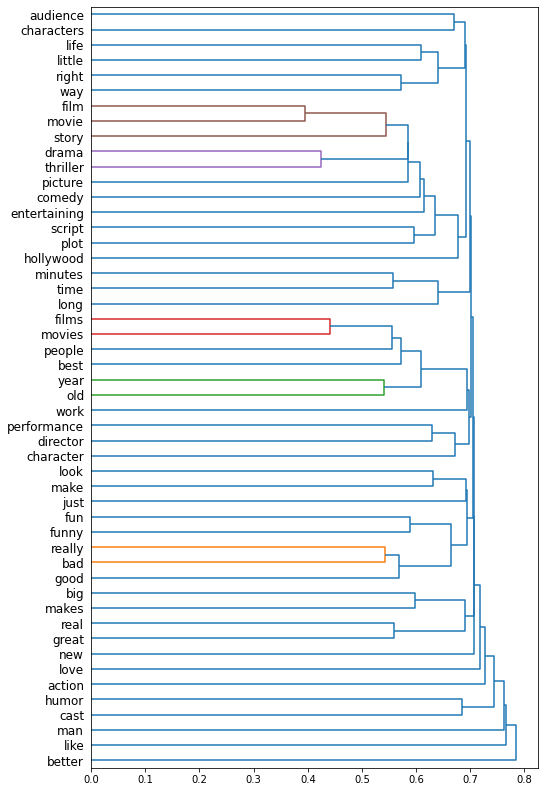

In [177]:
from sklearn.metrics.pairwise import cosine_distances
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.spatial.distance import squareform
import matplotlib.pyplot as plt

top_terms = list(stoplist_corpus.get_term_freq_df().sum(axis=1).sort_values(ascending=False).iloc[:50].index)
print('Top 50 terms')
print(top_terms)
mat = np.array([model.wv[t] for t in top_terms])
print('Embedding of "plot"')
print(model.wv['plot'])

def cosine_sim(a, b):
    return 1-np.dot(model.wv[a],model.wv[b])/(np.linalg.norm(model.wv[a])*np.linalg.norm(model.wv[b]))

print('Cosine distance of "plot" to "script"', cosine_sim('plot', 'script'))
print('Cosine distance of "dose" to "year"', cosine_sim('plot', 'year'))

#print('Dimensions of term/embedding matrix:', mat.shape)


sim_mat = cosine_distances(mat)
print('Dimension of pairwise cosine distance of matrix:', sim_mat.shape)
plt.figure(figsize=(8,14))
dists = squareform(sim_mat)
linkage_matrix = linkage(dists, "single")
dendrogram(linkage_matrix, labels=top_terms, orientation='right', leaf_font_size=12.,)
plt.show()

### UMAP Visualization of Emeddings
To get a sense of the embedding space, we can use UMAP to project the embedding space into two dimensions, where words whose embeddings have a small cosine distance are plotted close to each other.

In [255]:
emeddings = np.array([model.wv[w] for w in stoplist_corpus.get_terms()])
projection_raw = umap.UMAP(min_dist=0.5, metric='cosine').fit_transform(embeddings.T)

plot_df = pd.DataFrame({
    'term': stoplist_corpus.get_terms(),
    'X': projection_raw.T[0],
    'Y': projection_raw.T[1],
}).set_index('term').assign(
    XPos=lambda df: st.scale(df.X),
    YPos=lambda df: st.scale(df.Y),
    Color = '#6888BE'
)

html = st.dataframe_scattertext(
    stoplist_corpus,
    category='Positive',
    category_name='Positive',
    not_category_name='Negative',
    plot_df=plot_df,
    metadata=get_heading,
    ignore_categories=False,
    use_full_doc=True,
    x_label='UMAP 0',
    y_label='UMAP 1',
    y_axis_labels=['More Negative', 'Neutral', 'More Positive'],
    color_column='Color',
    show_top_terms=False,
    show_characteristic=False
)
fn = 'movie_umap.html'
open(fn, 'wb').write(('<h2>UMAP Projection of Skip-gram Embeddings</h2>' + html).encode('utf-8'))
IFrame(src=fn, width = 1300, height=700)

../scattertext/scattertext/Scalers.py:247: RuntimeWarning: invalid value encountered in true_divide
  vec_ss = (vec_ss - vec_ss.min()) * 1. / (vec_ss.max() - vec_ss.min())


We will focus on identifying words similar to "plot" to see how a movie's plot is described in a positive or negative context.

We first use Latent Semantic Scaling (Wantanabe, 2021) from the Gensim model we trained to compute the cosine similarity of the seed terms (in this case, only "plot") of all the terms in the positive seeds word list and 1 - the cosine similarity of the terms in the negative seed list. The average value cosine similarity of the positive and negative word lists is computed.

Terms are colored based on their similarity to the word "plot".

Kohei Watanabe. Latent Semantic Scaling: A Semisupervised Text Analysis Technique for New Domains and Languages. Communication Methods and Measures. 2021.

In [192]:
similar_df = pd.DataFrame({
    'Similarity': st.latent_semantic_scale_from_word2vec(
        model, 
        pos_seed_words=['plot']
    ),
    'Frequency': stoplist_corpus.get_term_freq_df().sum(axis=1),
}).dropna().sort_values(by='Similarity', ascending=False)
similar_df.head(10)

,Similarity,Frequency
plot,1.000000,99.0
twists,0.509917,14.0
stupidity,0.500536,6.0
screenplay,0.499689,30.0
holes,0.498362,12.0
clearly,0.494261,9.0
details,0.482726,7.0
parts,0.474063,7.0
surprises,0.452083,10.0
premise,0.440531,26.0


In [362]:
top_similar = similar_df.iloc[:200]
similar_corpus = stoplist_corpus.whitelist_terms(top_similar.index)

scorer = st.LogOddsRatioUninformativePriorScorer(similar_corpus).set_categories('Positive')

plot_df = top_similar.assign(
    SimilarScaled = lambda df: st.Scalers.scale(df.Similarity),
    Association = scorer.get_scores(),
    X = lambda df: df.Frequency,
    Xpos = lambda df: st.Scalers.dense_rank(df.X),
    Y = lambda df: df.Association,
    Ypos = lambda df: st.Scalers.scale_center_zero_abs(df.Y)
)


html = st.dataframe_scattertext(
    similar_corpus,
    category='Positive',
    category_name='Positive',
    not_category_name='Negative',
    plot_df=plot_df,
    metadata=get_heading,
    ignore_categories=False,
    use_full_doc=True,
    x_label='Frequency',
    y_label=scorer.get_name(),
    y_axis_labels=['More Negative', 'Neutral', 'More Positive'],
    color_score_column='Similarity',
    tooltip_columns=['Frequency', 'Association'],
    header_names={'upper': 'Top Positive', 'lower': 'Top Negative', 'right': 'Similarity'},
    left_list_column='Association',
    right_order_column='Similarity',    
    d3_color_scale='d3.interpolateCool'

)
fn = 'movie_plot_sim.html'
open(fn, 'wb').write(('<h2>Association to the word "Plot"</h2>' + html).encode('utf-8'))
IFrame(src=fn, width = 1300, height=700)



# Making use of pre-built lexicons

Empath (Fast et al., 2016) provides 100 (fix this) pre-built topics. It is integrated to scattertext throught the feature extraction class `FeatsFromOnlyEmpath`. 

Note that we used used `FlexibleNGrams` to construct the previous corpora we worked with. The features outputted are through `FeatsFromOnlyEmpath` considered non-text features (called "metadata" in some places in Scattertext; not to be confused with document headings in the visualization which are *also* called metadata).

Feature extraction classes output text features through `get_feats` and non-text features through `get_doc_metadata`. This may change as Scattertext matures.

Fast, Ethan, Binbin Chen, and Michael S. Bernstein. "Empath: Understanding topic signals in large-scale text." Proceedings of the 2016 CHI Conference on Human Factors in Computing Systems. ACM, 2016.

In [287]:
st.FeatsFromOnlyEmpath().get_doc_metadata(nlp('This is a scary story told by an author whose book was rejected by publishers 35 times.'))

Counter({'reading': 3, 'negative_emotion': 1, 'writing': 2})

In [294]:
st.FlexibleNGrams(ngram_sizes=[1,]).get_feats(nlp('This is a scary... story...'))

{'this': 1, 'is': 1, 'a': 1, 'scary': 1, '...': 2, 'story': 1}

In [365]:
feat_builder = st.FeatsFromOnlyEmpath()
empath_corpus = st.CorpusFromParsedDocuments(
    movie_df,
    category_col='category',
    parsed_col='SpacyParse',
    feats_from_spacy_doc=feat_builder
).build(show_progress=True)

plot_df = st.AbsoluteFrequencyRanker(
    empath_corpus
).set_non_text(
    non_text=True # Make sure you set this or you'll get a blank chart
).get_ranks(
    label_append=''
).assign(
    X=lambda df: df.Positive,
    Y=lambda df: df.Negative,
    PosRank = lambda df: ss.rankdata(df.X, method='dense'),
    NegRank = lambda df: ss.rankdata(df.Y, method='dense'),
    Xpos=lambda df: st.scale(df.NegRank),
    Ypos=lambda df: st.scale(df.PosRank),
    ColorScore=lambda df: st.Scalers.scale_center_zero(df.Ypos - df.Xpos),
)

line_df = pd.DataFrame({
    'x': np.arange(0, 1, 0.01),
    'y' :np.arange(0, 1, 0.01),
})


html = st.dataframe_scattertext(
    empath_corpus,
    plot_df=plot_df,
    category='Positive', 
    category_name='Positive',
    not_category_name='Negative',
    width_in_pixels=1000, 
    ignore_categories=False,    
    metadata=get_heading,
    color_score_column='ColorScore',
    left_list_column='ColorScore',
    show_characteristic=False,
    y_label='Positive Frequency Rank',
    x_label='Negative Frequency Rank',
    tooltip_columns=['PosRank', 'NegRank'],
    header_names={'upper': 'Top Positive', 'lower': 'Top Negative'},
    line_coordinates = line_df.to_dict('records'),   
    use_non_text_features=True,
    use_full_doc=True,
    topic_model_term_lists=feat_builder.get_top_model_term_lists()
)

fn = 'movie_empath.html'
with open(fn, 'w') as of:
    of.write(html)


IFrame(src=fn, width = 1300, height=700)

  0%|          | 0/4866 [00:00<?, ?it/s]

## We can also add in features from a custom lexicon

We create a data frame with topics that are columns, rows terms, and values real term-topic association.

Let's cluster sentences extracted from the corpus using NMF over TFIDF represendations

In [359]:
from sklearn.decomposition import NMF
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.pipeline import Pipeline


weight_df = st.SentencesForTopicModeling(
    stoplist_corpus
).get_topic_weights_df(
    Pipeline([
        ('tfidf', TfidfTransformer(sublinear_tf=True)),
        ('nmf', (NMF(n_components=10, l1_ratio=.5, random_state=0)))
    ])
)
    
weight_df.columns = [','.join(weight_df[c].sort_values(ascending=False).index[:2]) for c in weight_df]
weight_df.head()


/Users/jasonkessler/anaconda3/envs/py38/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:294: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  FutureWarning,


,"movie,action","film,family","like,feels","good,time","just,plain","comedy,romantic","story,characters","bad,really","best,year","funny,really"
captures,0.000000,0.000000,0.000020,0.000000,0.000166,0.001585,0.003246,0.00000,0.004970,0.000950
half,0.024194,0.016310,0.004189,0.007611,0.000000,0.054517,0.029282,0.02969,0.006742,0.000000
creepy,0.006038,0.000000,0.015603,0.000000,0.000000,0.002199,0.007007,0.00000,0.025728,0.001375
college,0.000000,0.000635,0.004807,0.001409,0.000000,0.010826,0.015951,0.00000,0.017203,0.000000
makes,0.050845,0.014484,0.099893,0.023608,0.000000,0.053221,0.136006,0.00000,0.050485,0.000000


In [431]:
feat_builder = st.FeatsFromScoredLexicon(lexicon_df = weight_df)
custom_topic_corpus = st.CorpusFromParsedDocuments(
    movie_df,
    category_col='category',
    parsed_col='SpacyParse',
    feats_from_spacy_doc=feat_builder
).build(show_progress=True)

plot_df = st.AbsoluteFrequencyRanker(
    custom_topic_corpus
).set_non_text(
    non_text=True # Make sure you set this or you'll get a blank chart
).get_ranks(
    label_append=''
).assign(
    X=lambda df: df.Positive,
    Y=lambda df: df.Negative,
    PosRank = lambda df: ss.rankdata(df.X, method='dense'),
    NegRank = lambda df: ss.rankdata(df.Y, method='dense'),
    Xpos=lambda df: st.scale(df.NegRank),
    Ypos=lambda df: st.scale(df.PosRank),
    ColorScore=lambda df: st.Scalers.scale_center_zero(df.Ypos - df.Xpos),
)

line_df = pd.DataFrame({
    'x': np.arange(0, 1, 0.01),
    'y' :np.arange(0, 1, 0.01),
})


html = st.dataframe_scattertext(
    custom_topic_corpus,
    plot_df=plot_df,
    category='Positive', 
    category_name='Positive',
    not_category_name='Negative',
    width_in_pixels=1000, 
    ignore_categories=False,    
    metadata=get_heading,
    color_score_column='ColorScore',
    left_list_column='ColorScore',
    show_characteristic=False,
    y_label='Positive Frequency Rank',
    x_label='Negative Frequency Rank',
    tooltip_columns=['PosRank', 'NegRank'],
    header_names={'upper': 'Top Positive', 'lower': 'Top Negative'},
    line_coordinates = line_df.to_dict('records'),   
    use_non_text_features=True,
    use_full_doc=True,
    topic_model_term_lists=feat_builder.get_top_model_term_lists()
)

fn = 'movie_custom_topics.html'
with open(fn, 'w') as of:
    of.write(html)


IFrame(src=fn, width = 1300, height=700)

  0%|          | 0/4866 [00:00<?, ?it/s]

../scattertext/scattertext/Scalers.py:247: RuntimeWarning: invalid value encountered in true_divide
  vec_ss = (vec_ss - vec_ss.min()) * 1. / (vec_ss.max() - vec_ss.min())


In [429]:
custom_topic_corpus._mX.todense().shape, custom_topic_corpus.get_metadata()
st.AbsoluteFrequencyRanker(
    custom_topic_corpus
).set_non_text(
    non_text=True # Make sure you set this or you'll get a blank chart
).get_ranks(
    label_append=''
)

,Negative,Positive
term,,
"movie,action",284.843574,199.032738
"film,family",129.911208,177.268661
"like,feels",108.871341,78.981447
"good,time",68.278976,87.853870
"just,plain",65.638103,38.672372
"comedy,romantic",63.822627,68.149268
"story,characters",81.242123,86.685145
"bad,really",52.095794,18.669299
"best,year",64.204509,95.352483


In [256]:
##### END OF PART 1 ####

In [389]:
custom_topic_corpus.get_metadata_fr

,Negative freq,Positive freq
term,,
"movie,action",NaN,NaN
"film,family",NaN,NaN
"like,feels",NaN,NaN
"good,time",NaN,NaN
"just,plain",NaN,NaN
"comedy,romantic",NaN,NaN
"story,characters",NaN,NaN
"bad,really",NaN,NaN
"best,year",NaN,NaN


In [ ]:
movie_corpus = unigram_corpus.recategorize(unigram_corpus.get_df()['movie_name'])

dispersion = st.Dispersion(
    movie_corpus,
    use_categories=True
)
dispersion_df=dispersion.get_df().assign(
    DA=dispersion.dp(),
    X=lambda df: df.Frequency,
    Xpos=lambda df: st.Scalers.log_scale(df.X),
    Y=lambda df: df.DA,
    Ypos=lambda df: st.Scalers.scale(df.Y)
)



In [ ]:
movie_corpus = unigram_corpus.recategorize(unigram_corpus.get_df()['movie_name'])

dispersion = st.Dispersion(
    movie_corpus,
    use_categories=True
)
dispersion_df=dispersion.get_df().assign(
    DA=dispersion.dp(),
    X=lambda df: df.Frequency,
    Xpos=lambda df: st.Scalers.log_scale(df.X),
    Y=lambda df: df.DA,
    Ypos=lambda df: st.Scalers.scale(df.Y),
    Expected=lambda df: st.smoothing.lowess.Lowess().fit(
        np.array([df.X.values]).T,
        df.Y.values
    ).predict(np.array([df.X.values]).T).T[0],
    Residual=lambda df: df.Ypos - st.scale(df.Y, df.Expected),
    ColorScore=lambda df: 1 #st.Scalers.scale(df.DA)
)

line_df = pd.DataFrame({
    'x': dispersion_df.Xpos.values,
    'y': dispersion_df.Expected.values,
}).sort_values(by='x')

html = st.dataframe_scattertext(
    movie_corpus,
    plot_df=dispersion_df,
    metadata=get_heading,
    ignore_categories=False,
    x_label='Log Frequency',
    y_label='DA',
    y_axis_labels=['More Dispersion', 'Medium', 'Less Dispersion'],
    color_score_column='ColorScore',
    tooltip_columns=['Frequency', 'DA'],
    header_names={'upper': 'Top DA', 'lower': 'Bottom DA'},
    left_list_column='DA',
    show_characteristic=False,
    line_coordinates = line_df.to_dict('records')
)

fn = 'movie_dispersion.html'
open(fn, 'w').write(html)
IFrame(src=fn, width = 1300, height=700)

In [ ]:

residual_df = dispersion_df.assign(
    Y = lambda df: df.Residual,
    Ypos = lambda df: st.Scalers.scale_center_zero(df.Y)
)

line_df = pd.DataFrame({
    'x': residual_df.Xpos.values,
    'y': 0.5,
}).sort_values(by='x')

html = st.dataframe_scattertext(
    unigram_corpus,
    category='Positive',
    category_name='Positive',
    not_category_name='Negative',
    plot_df=residual_df,
    metadata=get_heading,
    ignore_categories=False,
    sort_doc_labels_by_name=True,
    x_label='Log Frequency',
    y_label='Residual: DA - E-hat[DA]',
    y_axis_labels=['More Dispersion', 'Medium', 'Less Dispersion'],
    color_score_column='ColorScore',
    tooltip_columns=['Frequency', 'Residual'],
    header_names={'upper': 'Lower than Expected', 'lower': 'More than Expected', 'right': 'Frequency'},
    left_list_column='Residual',
    right_order_column='Frequency',    
    line_coordinates = line_df.to_dict('records'),
    show_corpus_stats=False
)

fn = 'movie_dispersion_residual.html'
open(fn, 'w').write(html)
IFrame(src=fn, width = 1300, height=700)

In [ ]:
dispersion_df=st.get_category_dispersion(
    corpus=unigram_corpus,
    corpus_to_parts=lambda corpus: corpus.get_df()['movie_name'],
    metric='DA',
    non_text=False
)

coordinates = st.Scalers.scale_jointly(
    x=st.Scalers.log_scale(dispersion_df.Negative_DA + 0.01), 
    y=st.Scalers.log_scale(dispersion_df.Positive_DA + 0.01)
)

dispersion_df = dispersion_df.assign(
    X=lambda df: df.Negative_DA,
    Xpos=lambda df: coordinates.x,
    Y=lambda df: df.Positive_DA,
    Ypos=lambda df: coordinates.y,
    ColorScore=lambda df: st.Scalers.scale_center_zero(df.Y-df.X),
    Frequency=lambda df: df.Positive_Frequency+df.Negative_Frequency
)

html = st.dataframe_scattertext(
    unigram_corpus,
    category='Positive',
    category_name='Positive',
    not_category_name='Negative',    
    plot_df=dispersion_df,
    metadata=get_heading,
    ignore_categories=False,
    x_label='Negative Log DA',
    y_label='Positive Log DA',
    y_axis_labels=['Less Dispersion', 'Medium', 'More Dispersion'],
    x_axis_labels=['Less Dispersion', 'Medium', 'More Dispersion'],
    color_score_column='ColorScore',
    tooltip_columns=['Positive_DA', 'Negative_DA'],
    header_names={'upper': 'Top Positive', 'lower': 'Top Negative', 'right': 'Frequency'},
    left_list_column='ColorScore',
    right_order_column='Frequency',    
)

fn = 'movie_pos_da_neg_da.html'
open(fn, 'w').write(html)
IFrame(src=fn, width = 1300, height=700)

In [ ]:
positive_corpus = unigram_corpus.remove_categories(['Negative']).recategorize(
    lambda corpus: corpus.get_df()['movie_name']
)

plot_df = st.Dispersion(
    positive_corpus, use_categories=True
).get_adjusted_metric_df()

plot_df = plot_df.assign(
    X=lambda df: df.Frequency,
    Xpos=lambda df: st.Scalers.log_scale(df.X),
    Y=lambda df: df.Residual,
    Ypos=lambda df: st.Scalers.scale_center_zero_abs(df.Residual),
    ColorScore=lambda df: st.Scalers.scale_center_zero_abs(df.Residual),
)

html = st.dataframe_scattertext(
    positive_corpus,
    plot_df=plot_df,
    metadata=get_heading,
    unified_context=True,
    ignore_categories=False,
    show_corpus_stats=False,
    x_label='Log Frequency',
    y_label='Residual DA',
    y_axis_labels=['Less Dispersion', 'Medium', 'More Dispersion'],
    #x_axis_labels=['Less Dispersion', 'Medium', 'More Dispersion'],
    color_score_column='ColorScore',
    tooltip_columns=['Frequency', 'Residual'],
    header_names={'upper': 'Top Residual', 'lower': 'Bottom Residual', 'right': 'Frequency'},
    left_list_column='ColorScore',
    right_order_column='Frequency',    
)

fn = 'movie_pos_residual.html'
open(fn, 'w').write(html)
IFrame(src=fn, width = 1300, height=700)

In [ ]:
negative_corpus = unigram_corpus.remove_categories(['Positive']).recategorize(
    lambda corpus: corpus.get_df()['movie_name']
)

plot_df = st.Dispersion(
    negative_corpus, use_categories=True
).get_adjusted_metric_df()

plot_df = plot_df.assign(
    X=lambda df: df.Frequency,
    Xpos=lambda df: st.Scalers.log_scale(df.X),
    Y=lambda df: df.Residual,
    Ypos=lambda df: st.Scalers.scale_center_zero_abs(df.Residual),
    ColorScore=lambda df: st.Scalers.scale_center_zero_abs(df.Residual),
)

html = st.dataframe_scattertext(
    negative_corpus,
    plot_df=plot_df,
    metadata=get_heading,
    unified_context=True,
    ignore_categories=False,
    show_corpus_stats=False,
    x_label='Log Frequency',
    y_label='Residual DA',
    y_axis_labels=['Less Dispersion', 'Medium', 'More Dispersion'],
    #x_axis_labels=['Less Dispersion', 'Medium', 'More Dispersion'],
    color_score_column='ColorScore',
    tooltip_columns=['Frequency', 'Residual'],
    header_names={'upper': 'Top Residual', 'lower': 'Bottom Residual', 'right': 'Frequency'},
    left_list_column='ColorScore',
    right_order_column='Frequency',    
)

fn = 'movie_neg_residual.html'
open(fn, 'w').write(html)
IFrame(src=fn, width = 1300, height=700)

In [ ]:

plot_df = st.Dispersion(
    positive_corpus, use_categories=True
).get_adjusted_metric_df()

plot_df = plot_df.assign(
    X=lambda df: df.Frequency,
    Xpos=lambda df: st.Scalers.log_scale(df.X),
    Y=lambda df: df.Residual,
    Ypos=lambda df: st.Scalers.scale_center_zero_abs(df.Residual),
    ColorScore=lambda df: st.Scalers.scale_center_zero_abs(df.Residual),
)

html = st.dataframe_scattertext(
    positive_corpus,
    plot_df=plot_df,
    metadata=get_heading,
    unified_context=True,
    ignore_categories=False,
    show_corpus_stats=False,
    x_label='Log Frequency',
    y_label='Residual DA',
    y_axis_labels=['Less Dispersion', 'Medium', 'More Dispersion'],
    #x_axis_labels=['Less Dispersion', 'Medium', 'More Dispersion'],
    color_score_column='ColorScore',
    tooltip_columns=['Frequency', 'Residual'],
    header_names={'upper': 'Top Residual', 'lower': 'Bottom Residual', 'right': 'Frequency'},
    left_list_column='ColorScore',
    right_order_column='Frequency',    
)

fn = 'movie_pos_residual.html'
open(fn, 'w').write(html)
IFrame(src=fn, width = 1300, height=700)

In [ ]:
st.Scalers